In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision = 4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import logging
!pip install tensorflow==2.3.0
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel(logging.ERROR)

In [3]:
print(tf.__version__)

2.3.0


In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

In [6]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)

In [7]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [8]:
class action_space:
  def __init__(self, n):
    s = np.linspace(0, 1, num = 5)
    self.array = s
    
  def seed(self, seed):
    pass

  def sample(self):
    return np.random.choice(self.array)

In [9]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

    def __init__(self, symbol0, symbol1, features, window, lags, leverage = 1, min_performance = 0.85, start = 0, end = None, action_space_N = 5):
        self.symbol0 = symbol0
        self.symbol1 = symbol1
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(action_space_N)
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col = False, parse_dates = False).dropna()

    def _prepare_data(self):
        self.data0 = pd.DataFrame(self.raw[self.symbol0])
        self.data0 = self.data0.iloc[self.start:]
        self.data0 = self.data0.shift(1) / self.data0
        self.data0.dropna(inplace = True)
        if self.end is not None:
            self.data0 = self.data0.iloc[:self.end - self.start]

        self.data1 = pd.DataFrame(self.raw[self.symbol1])
        self.data1 = self.data1.iloc[self.start:]
        self.data1 = self.data1.shift(1) / self.data1
        self.data1.dropna(inplace = True)
        if self.end is not None:
            self.data1 = self.data1.iloc[:self.end - self.start]
        
        self.data = self.data0.join(self.data1)

    def _get_state(self):
        return self.data[self.features].iloc[self.bar - self.lags:self.bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.performance = 1
        self.bar = self.lags
        state = self.data[self.features].iloc[self.bar - self.lags:self.bar]
        return state.values

    def step(self, action):
        ret0 = self.data[symbol0].iloc[self.bar]
        ret1 = self.data[symbol1].iloc[self.bar]
        reward = np.log(ret0 * action + ret1 * (1 - action))
        self.bar += 1
        self.performance *= math.exp(reward)
        if self.bar >= len(self.data):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward, done, info

In [10]:
symbol0 = 'EUR='
symbol1 = 'GLD'
env = Finance(symbol0, symbol1, [symbol0, symbol1], 10, 5)

In [11]:
from collections import deque

In [12]:
class FQLAgent:
    def __init__(self, hidden_units, lr, learn_env, valid_env, action_space_N = 5):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.gamma = 0.99
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen = 2000)
        self.model = self._build_model(hidden_units, lr)
        
    def _build_model(self, hu, lr, action_space_N = 5):
        model = Sequential()
        model.add(Dense(hu, input_shape = (self.learn_env.lags, self.learn_env.n_features), activation = 'relu'))
        model.add(Dense(hu, activation = 'relu'))
        model.add(Dense(action_space_N, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = lr))
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.learn_env.action_space.array[np.argmax(self.model.predict(state)[0, 0])]
        return action
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                Q = reward + self.gamma * np.amax(self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, np.where(np.isclose(self.learn_env.action_space.array, action))] = Q 
            self.model.fit(state, target, epochs = 1, verbose = False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags, self.learn_env.n_features])
            treward = 0
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = self.learn_env.step(action)
                next_state = np.reshape(next_state, [1, self.learn_env.lags, self.learn_env.n_features])
                self.memory.append([state, action, reward, next_state, done])
                state = next_state
                treward += reward
                if done:
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
            self.validate(e, episodes)

    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags, self.valid_env.n_features])
        treward = 0
        for _ in range(10000):
            action = self.valid_env.action_space.array[np.argmax(self.model.predict(state)[0, 0])]
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags, self.valid_env.n_features])
            treward += reward
            if done:
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4f} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, np.exp(treward), perf, self.epsilon))
                break

In [13]:
features = [symbol0, symbol1]

In [14]:
a = 0
b = 2000
c = 500

In [15]:
learn_env = Finance(symbol0, symbol1, features, window=10, lags=6, leverage=1, min_performance=0.85, start=a, end=a + b)

In [16]:
valid_env = Finance(symbol0, symbol1, features, window=learn_env.window, lags=learn_env.lags, leverage=learn_env.leverage, min_performance=learn_env.min_performance, start=a + b, end=a + b + c)

In [17]:
set_seeds(100)
agent = FQLAgent(25, 0.005, learn_env, valid_env)

In [18]:
episodes = 60
print(agent.learn_env.reset())

[[1.003  1.0009]
 [0.9969 0.9838]
 [1.0066 1.0062]
 [0.9935 0.9951]
 [0.993  0.9869]
 [1.0013 1.0214]]


In [19]:
%time agent.learn(episodes)

episode: 20/60 | VALIDATION | treward: 0.920894 | perf: 0.921 | eps: 0.67
episode: 40/60 | VALIDATION | treward: 0.920894 | perf: 0.921 | eps: 0.45
episode: 60/60 | VALIDATION | treward: 0.970085 | perf: 0.970 | eps: 0.30
CPU times: user 3min 56s, sys: 5.88 s, total: 4min 2s
Wall time: 3min 50s


In [20]:
agent.epsilon

0.2975531426921204

No handles with labels found to put in legend.


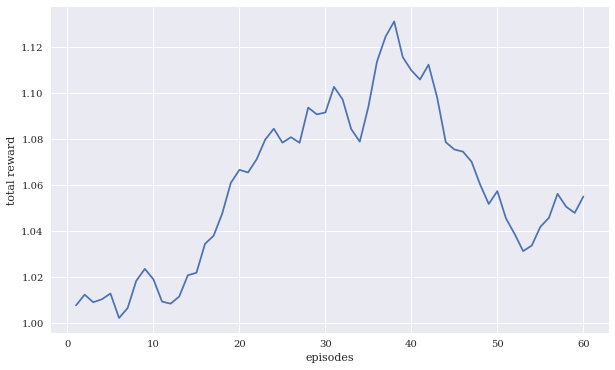

In [21]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = plt.plot(x, np.exp(agent.averages))
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

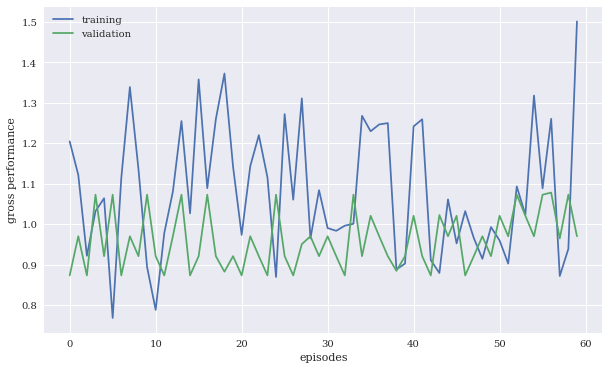

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend();

In [23]:
ret0 = valid_env.data[symbol0].to_numpy()
ret1 = valid_env.data[symbol1].to_numpy()

s = np.linspace(0, 1, num = 5)

for d in s:
  V = 1
  for i in range(0, 499):
    V *= ret0[i] * d + ret1[i] * (1 - d)
  temp = 'При фиксированной доле d = {:4f} капитал V = {:5.3f}'
  print(temp.format(d, V))
  print()

print()
print('В результате применения нейросети (средний за последние 10 итераций) капитал V = ', sum(agent.vperformances[-10:]) / 10)

При фиксированной доле d = 0.000000 капитал V = 0.859

При фиксированной доле d = 0.250000 капитал V = 0.907

При фиксированной доле d = 0.500000 капитал V = 0.957

При фиксированной доле d = 0.750000 капитал V = 1.009

При фиксированной доле d = 1.000000 капитал V = 1.062


В результате применения нейросети (средний за последние 10 итераций) капитал V =  1.0213456310949667


In [31]:
state = agent.learn_env.reset()
state = np.reshape(state, [1, agent.learn_env.lags, agent.learn_env.n_features])
treward = 0
for _ in range(500):
  action = agent.learn_env.action_space.array[np.argmax(agent.model.predict(state)[0, 0])]
  next_state, reward, done, info = agent.learn_env.step(action)
  state = np.reshape(next_state, [1, agent.learn_env.lags, agent.learn_env.n_features])
  treward += reward